In [ ]:
movie_data = """MovieID,Title,Genre,ReleaseDate,Rating,Revenue,Budget
1,Inception,Sci-Fi,2010-07-16,8.8,825532764,160000000
2,The Dark Knight,Action,2008-07-18,9.0,1004558444,185000000
3,Titanic,Romance,1997-12-19,7.8,2187463944,200000000
4,Interstellar,Sci-Fi,2014-11-07,8.6,677471339,165000000
5,Joker,Drama,2019-10-04,8.4,1074251311,55000000
6,The Notebook,Romance,2004-06-25,7.9,,29000000
7,Avengers: Endgame,Action,2019-04-26,8.4,2797800564,356000000
"""

with open("movies.csv", "w") as f:
    f.write(movie_data)


# PART 1: Pandas Operations
1. Load movies.csv into a Pandas DataFrame.
2. Convert ReleaseDate to datetime.
3. Calculate Profit = Revenue - Budget .
4. Add a column "Era" :
Before 2000 → Classic
2000-2010 → Mid
After 2010 → Modern
5. Handle nulls in Revenue by filling with average revenue.
6. Sort by Rating descending.
7. Group by Genre → average Rating & total Revenue.
8. Filter movies with Rating ≥ 8.5 and Profit >
500M.

9. Plot bar chart of Movie Title vs Profit.

         Rating       Revenue
Genre                        
Action     8.70  3.802359e+09
Drama      8.40  1.074251e+09
Romance    7.85  3.615310e+09
Sci-Fi     8.70  1.503004e+09
   MovieID            Title   Genre ReleaseDate  Rating       Revenue  \
0        1        Inception  Sci-Fi  2010-07-16     8.8  8.255328e+08   
1        2  The Dark Knight  Action  2008-07-18     9.0  1.004558e+09   
3        4     Interstellar  Sci-Fi  2014-11-07     8.6  6.774713e+08   

      Budget       Profit     Era  
0  160000000  665532764.0     Mid  
1  185000000  819558444.0     Mid  
3  165000000  512471339.0  Modern  


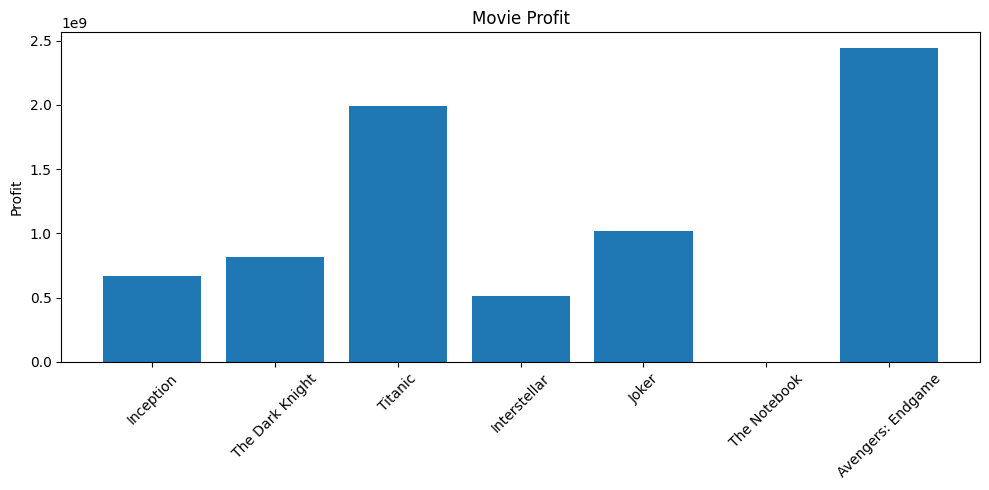

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load CSV
df = pd.read_csv("movies.csv")

# 2. Convert ReleaseDate to datetime
df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'])

# 3. Calculate Profit
df['Profit'] = df['Revenue'] - df['Budget']

# 4. Add Era column
def classify_era(date):
    year = date.year
    if year < 2000:
        return 'Classic'
    elif year <= 2010:
        return 'Mid'
    else:
        return 'Modern'

df['Era'] = df['ReleaseDate'].apply(classify_era)

# 5. Handle null Revenue with average
df['Revenue'] = df['Revenue'].fillna(df['Revenue'].mean())

# 6. Sort by Rating descending
df_sorted = df.sort_values(by='Rating', ascending=False)

# 7. Group by Genre → avg Rating, total Revenue
grouped = df.groupby('Genre').agg({'Rating': 'mean', 'Revenue': 'sum'})
print(grouped)

# 8. Filter: Rating ≥ 8.5 and Profit > 500M
filtered = df[(df['Rating'] >= 8.5) & (df['Profit'] > 500_000_000)]
print(filtered)

# 9. Plot bar chart: Title vs Profit
plt.figure(figsize=(10, 5))
plt.bar(df['Title'], df['Profit'])
plt.title("Movie Profit")
plt.xticks(rotation=45)
plt.ylabel("Profit")
plt.tight_layout()
plt.show()


# PART 2: PySpark Operations
1. Read the same CSV using PySpark.
2. Create Profit column ( Revenue - Budget ).
3. Filter where Genre == 'Sci-Fi' and Profit > 500000000 .
4. Group by Genre → avg(Rating) , sum(Profit)
5. Use when().otherwise() to classify Rating as:
  =9 → Blockbuster
  8–9 → Hit
  below 8 → Average
6. Drop the Budget column.
7. Fill null revenue with average (use na.fill() or na.replace() ).
8. Convert ReleaseDate to date type, extract year and month .
9. Use a window function to rank movies within each genre by profit.

In [ ]:
from pyspark.sql import SparkSession
# Create Spark session

spark = SparkSession.builder \
.appName("Pysparkass3") \
.getOrCreate()

# Confirm Spark is running

spark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window

spark = SparkSession.builder.appName("MovieAnalysis").getOrCreate()

In [ ]:
# 1. Load the csv
df_spark = spark.read.csv("movies.csv", header=True, inferSchema=True)


In [ ]:
df_spark = df_spark.withColumn("Profit", col("Revenue") - col("Budget"))


In [ ]:
df_spark.filter((col("Genre") == "Sci-Fi") & (col("Profit") > 500_000_000)).show()


+-------+------------+------+-----------+------+---------+---------+---------+
|MovieID|       Title| Genre|ReleaseDate|Rating|  Revenue|   Budget|   Profit|
+-------+------------+------+-----------+------+---------+---------+---------+
|      1|   Inception|Sci-Fi| 2010-07-16|   8.8|825532764|160000000|665532764|
|      4|Interstellar|Sci-Fi| 2014-11-07|   8.6|677471339|165000000|512471339|
+-------+------------+------+-----------+------+---------+---------+---------+



In [ ]:
df_spark.groupBy("Genre").agg(avg("Rating").alias("AvgRating"), sum("Profit").alias("TotalProfit")).show()


+-------+---------+-----------+
|  Genre|AvgRating|TotalProfit|
+-------+---------+-----------+
|Romance|     7.85| 1987463944|
|  Drama|      8.4| 1019251311|
| Action|      8.7| 3261359008|
| Sci-Fi|      8.7| 1178004103|
+-------+---------+-----------+



In [ ]:
df_spark = df_spark.withColumn(
    "RatingClass",
    when(col("Rating") == 9.0, "Blockbuster")
    .when((col("Rating") >= 8.0) & (col("Rating") < 9.0), "Hit")
    .otherwise("Average")
)
print(df_spark)

DataFrame[MovieID: int, Title: string, Genre: string, ReleaseDate: date, Rating: double, Revenue: bigint, Profit: bigint, RatingClass: string]


In [ ]:
df_spark = df_spark.drop("Budget")
df_spark.show()


+-------+-----------------+-------+-----------+------+----------+----------+-----------+----+-----+----------+
|MovieID|            Title|  Genre|ReleaseDate|Rating|   Revenue|    Profit|RatingClass|Year|Month|ProfitRank|
+-------+-----------------+-------+-----------+------+----------+----------+-----------+----+-----+----------+
|      7|Avengers: Endgame| Action| 2019-04-26|   8.4|2797800564|2441800564|        Hit|2019|    4|         1|
|      2|  The Dark Knight| Action| 2008-07-18|   9.0|1004558444| 819558444|Blockbuster|2008|    7|         2|
|      5|            Joker|  Drama| 2019-10-04|   8.4|1074251311|1019251311|        Hit|2019|   10|         1|
|      3|          Titanic|Romance| 1997-12-19|   7.8|2187463944|1987463944|    Average|1997|   12|         1|
|      6|     The Notebook|Romance| 2004-06-25|   7.9|1427846394|      NULL|    Average|2004|    6|         2|
|      1|        Inception| Sci-Fi| 2010-07-16|   8.8| 825532764| 665532764|        Hit|2010|    7|         1|
|

In [ ]:
avg_rev = df_spark.select(avg("Revenue")).first()[0]
df_spark = df_spark.fillna({"Revenue": avg_rev})
df_spark.show()


+-------+-----------------+-------+-----------+------+----------+----------+-----------+----+-----+----------+
|MovieID|            Title|  Genre|ReleaseDate|Rating|   Revenue|    Profit|RatingClass|Year|Month|ProfitRank|
+-------+-----------------+-------+-----------+------+----------+----------+-----------+----+-----+----------+
|      7|Avengers: Endgame| Action| 2019-04-26|   8.4|2797800564|2441800564|        Hit|2019|    4|         1|
|      2|  The Dark Knight| Action| 2008-07-18|   9.0|1004558444| 819558444|Blockbuster|2008|    7|         2|
|      5|            Joker|  Drama| 2019-10-04|   8.4|1074251311|1019251311|        Hit|2019|   10|         1|
|      3|          Titanic|Romance| 1997-12-19|   7.8|2187463944|1987463944|    Average|1997|   12|         1|
|      6|     The Notebook|Romance| 2004-06-25|   7.9|1427846394|      NULL|    Average|2004|    6|         2|
|      1|        Inception| Sci-Fi| 2010-07-16|   8.8| 825532764| 665532764|        Hit|2010|    7|         1|
|

In [ ]:
df_spark = df_spark.withColumn("ReleaseDate", to_date("ReleaseDate"))
df_spark = df_spark.withColumn("Year", year("ReleaseDate"))
df_spark = df_spark.withColumn("Month", month("ReleaseDate"))
df_spark.show()


+-------+-----------------+-------+-----------+------+----------+----------+-----------+----+-----+----------+
|MovieID|            Title|  Genre|ReleaseDate|Rating|   Revenue|    Profit|RatingClass|Year|Month|ProfitRank|
+-------+-----------------+-------+-----------+------+----------+----------+-----------+----+-----+----------+
|      7|Avengers: Endgame| Action| 2019-04-26|   8.4|2797800564|2441800564|        Hit|2019|    4|         1|
|      2|  The Dark Knight| Action| 2008-07-18|   9.0|1004558444| 819558444|Blockbuster|2008|    7|         2|
|      5|            Joker|  Drama| 2019-10-04|   8.4|1074251311|1019251311|        Hit|2019|   10|         1|
|      3|          Titanic|Romance| 1997-12-19|   7.8|2187463944|1987463944|    Average|1997|   12|         1|
|      6|     The Notebook|Romance| 2004-06-25|   7.9|1427846394|      NULL|    Average|2004|    6|         2|
|      1|        Inception| Sci-Fi| 2010-07-16|   8.8| 825532764| 665532764|        Hit|2010|    7|         1|
|

In [ ]:
windowSpec = Window.partitionBy("Genre").orderBy(col("Profit").desc())
df_spark = df_spark.withColumn("ProfitRank", rank().over(windowSpec))
df_spark.select("Title", "Genre", "Profit", "ProfitRank").show()


+-----------------+-------+----------+----------+
|            Title|  Genre|    Profit|ProfitRank|
+-----------------+-------+----------+----------+
|Avengers: Endgame| Action|2441800564|         1|
|  The Dark Knight| Action| 819558444|         2|
|            Joker|  Drama|1019251311|         1|
|          Titanic|Romance|1987463944|         1|
|     The Notebook|Romance|      NULL|         2|
|        Inception| Sci-Fi| 665532764|         1|
|     Interstellar| Sci-Fi| 512471339|         2|
+-----------------+-------+----------+----------+



# PART 3: JSON + Union Example
movies_bonus.json
1. Read this JSON using PySpark.
2. Union it with your original movies DataFrame.
3. Show top 5 highest grossing movies.
4. Save final merged DataFrame as CSV.
Bonus:
Create a column ReturnOnInvestment = Profit / Budget
Show top ROI movies (minimum budget
50M)
Plot genre-wise ROI as a bar chart using Pandas

In [ ]:
import json

json_data = [
    {"MovieID": 8, "Title": "Barbie", "Genre": "Drama", "Rating": 7.5, "Revenue": 1456000000, "Budget": 145000000},
    {"MovieID": 9, "Title": "Oppenheimer", "Genre": "Drama", "Rating": 8.6, "Revenue": 950000000, "Budget": 100000000}
]

with open("movies_bonus.json", "w") as f:
    json.dump(json_data, f, indent=2)


In [ ]:
df_bonus = spark.read.json("movies_bonus.json", multiLine=True)
df_bonus = df_bonus.withColumn("Profit", col("Revenue") - col("Budget"))


In [ ]:
df_combined = df_spark.unionByName(df_bonus, allowMissingColumns=True)


In [ ]:
df_combined.orderBy(col("Revenue").desc()).select("Title", "Revenue").show(5)


+-----------------+----------+
|            Title|   Revenue|
+-----------------+----------+
|Avengers: Endgame|2797800564|
|          Titanic|2187463944|
|           Barbie|1456000000|
|     The Notebook|1427846394|
|            Joker|1074251311|
+-----------------+----------+
only showing top 5 rows



In [ ]:
df_combined.coalesce(1).write.csv("merged_movies.csv", header=True, mode="overwrite")


         Title       ROI
7       Barbie  9.041379
8  Oppenheimer  8.500000


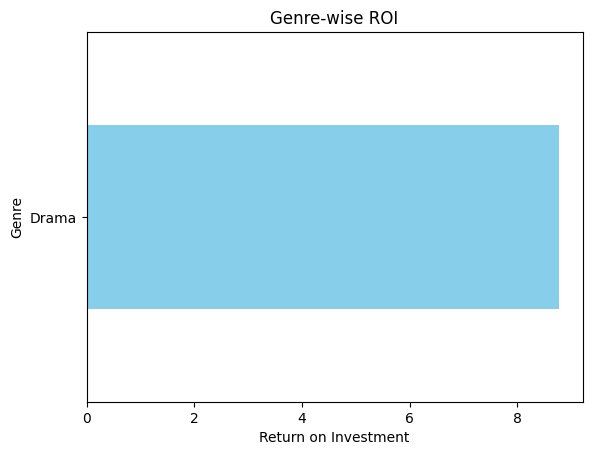

In [ ]:
df_combined_pd = df_combined.toPandas()
df_combined_pd['ROI'] = df_combined_pd['Profit'] / df_combined_pd['Budget']
roi_filtered = df_combined_pd[df_combined_pd['Budget'] > 50_000_000]
top_roi = roi_filtered.sort_values(by='ROI', ascending=False)
print(top_roi[['Title', 'ROI']])

# Plot Genre-wise ROI
genre_roi = roi_filtered.groupby('Genre')['ROI'].mean().sort_values()
genre_roi.plot(kind='barh', title='Genre-wise ROI', color='skyblue')
plt.xlabel("Return on Investment")
plt.show()
